<a href="https://colab.research.google.com/github/IpastorSan/seq2seq-with-attention-OCR-translation/blob/master/vanilla_seq2seq_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#1)Relevant Imports

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import GRU, Input, Dense, Embedding, Bidirectional, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, KeyedVectors
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
######Data Preparation#######

def open_data(dataset, num_examples=None):
    with open(dataset) as archivo:
        datos = [line.rstrip('\n') for line in archivo]
        corpus = datos[:num_examples]

    return corpus


# Corpus. Adapt the path to your directory
num_examples = 20000
corpus_zh = open_data("/content/gdrive/My Drive/tfm/dataset_zh.txt", num_examples=num_examples)
corpus_en = open_data("/content/gdrive/My Drive/tfm/dataset_en.txt", num_examples=num_examples)


#2)Maximum length, Tokenizer, Pretrained, embeddings and batch generator

##2.1)max len

In [4]:
def max_len(data):
    return max(len(line.split()) for line in data)

# Set max len
zh_max_len = max_len(corpus_zh)
en_max_len = max_len(corpus_en)
global_max_len = max(en_max_len, zh_max_len)  #This helps us when training the model, setting all lengths to the maximum

##2.2 Tokenizer

In [5]:
def tokenizer(dataset, max_len, max_features, language="en"):
    tokenizer_lang = Tokenizer(num_words=max_features, filters="")

    tokenizer_lang.fit_on_texts(dataset)

    word_tensor = tokenizer_lang.texts_to_sequences(dataset)
    word_tensor = tf.keras.preprocessing.sequence.pad_sequences(word_tensor,maxlen=max_len, padding="post")

    return tokenizer_lang, word_tensor  #dictionary with tokenized words/sequences translated to numbers

# Tokenizacion. We obtain tokenizer and sequences
zh_tokenizer_lang, zh_word_tensor = tokenizer(corpus_zh, global_max_len, max_features=3000)
en_tokenizer_lang, en_word_tensor = tokenizer(corpus_en, global_max_len, max_features=3000)

In [6]:
# Length of each set of vocabulary
zh_vocab_size = len(zh_tokenizer_lang.word_index)
en_vocab_size = len(en_tokenizer_lang.word_index)

In [7]:
#Split the dataset into train and test sets
zh_train, zh_test, en_train, en_test = train_test_split(zh_word_tensor, en_word_tensor, test_size=0.1, random_state=13)

##2.3 Embeddings

In [8]:
#Preparation of embedding files.
#Source Chinese Embedding: https://github.com/Kyubyong/wordvectors
#Source English Embedding: https://fasttext.cc/docs/en/english-vectors.html
#All embeddings come from word2vec models

embedding_file_en = "/content/gdrive/My Drive/tfm/en.bin"
embedding_file_zh = "/content/gdrive/My Drive/tfm/zh.bin"


def from_w2v_to_dict(embedding_file, lang="zh"):
    if lang == "en":
        model = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
    else:
        model = Word2Vec.load(embedding_file)

    vector = model.wv.vectors
    words = model.wv.index2word
    union_embeddings = dict(zip(words, vector))
    return union_embeddings

In [9]:
embedding_zh = from_w2v_to_dict(embedding_file_zh)
embedding_en = from_w2v_to_dict(embedding_file_en, lang="en")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [10]:
#Extract embedding weights to input into Keras Embedding Layer. Words not found in the embedding
#will be substitued with a random vector with normal distribution with mean=embedding mean and std=embedding std


def get_embedding_weights(embedd_dict, tokenizer_index, max_features=1000):
    embed = list(embedd_dict.values())

    all_embs = np.stack(embed)
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]  # probar

    word_index = tokenizer_index.word_index
    nb_words = len(word_index)

    embedding_matrix = np.random.normal(emb_mean, emb_std, \
                                        size=(nb_words, embed_size))

    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = np.array(embedd_dict.get(word))
        if embedding_vector.size is not 1:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [11]:
emb_zh = get_embedding_weights(embedding_zh, zh_tokenizer_lang, max_features=zh_vocab_size)
emb_en = emb = get_embedding_weights(embedding_en, en_tokenizer_lang, max_features=en_vocab_size)

##2.4 Batch Generator

In [12]:
########Batch Generator for training. We also implement teacher forcing here######

def generate_batch(X, y, global_max_len, vocab_size_out, batch_size):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, global_max_len), dtype='float32')
            decoder_input_data = np.zeros((batch_size, global_max_len), dtype='float32')
            decoder_target_data = np.zeros((batch_size, global_max_len, vocab_size_out), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j + batch_size], y[j:j + batch_size])):
                for t, word in enumerate(input_text):
                    encoder_input_data[i, t] = word  # encoder input seq
                for t, word in enumerate(target_text):
                    if t < len(target_text) - 1:
                        decoder_input_data[i, t] = word  # decoder input seq
                    if t > 0:
                        # decoder target sequence (one hot encoded)
                        # does not include the "start" token and is offset by one timestep
                        decoder_target_data[i, t - 1, word] = 1  # si el vector es (1, 2, 4) ese 4 es 0001
            yield ([encoder_input_data, decoder_input_data], decoder_target_data)

#This will be substitued by a tf.Dataset

#3) Encoder-Decoder for training

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 300)      3168600     input_2[0][0]                    
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 17)]         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 17, 2048), ( 8146944     embedding_2[0][0]                
_______________________________________________________________________________________

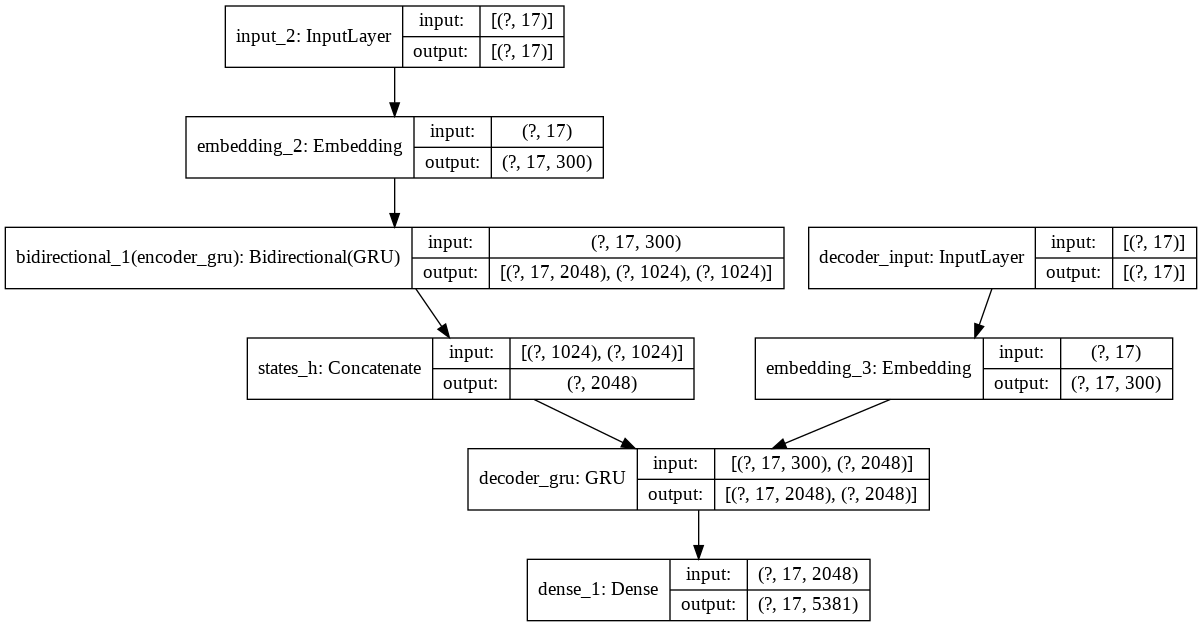

In [15]:
###########Model for training. GRU units, Bidirectional, without Attention#########

#Model seq2seq

nodes = 1024
learning_rate = 0.001
clip_value = 1
dropout = 0.01

# encoder-Chinese
encoder_input = Input(shape=(global_max_len,))
#mask_zero=True allows for the padding 0 at the end of the sequence to be ignored
encoder_embedding = Embedding(zh_vocab_size, 300, input_length=global_max_len, mask_zero=True)(encoder_input)
encoder_gru = Bidirectional(GRU(nodes, return_sequences=True,unroll=True, dropout=dropout,\
                                return_state=True, name="encoder_gru"))
encoder_output, state_h_f, state_h_b = encoder_gru(encoder_embedding)
state_h = Concatenate(name="states_h")([state_h_f, state_h_b])


# decoder-English
decoder_input = Input(shape=(global_max_len), name="decoder_input")
decoder_emb = Embedding(en_vocab_size, 300, input_length=global_max_len,mask_zero=True)(decoder_input)


decoder_gru = GRU(nodes* 2, return_sequences=True, return_state=True,unroll=True,\
                  dropout=dropout,name="decoder_gru")

decoder_output, _ = decoder_gru(decoder_emb, initial_state=state_h)

#Decoder Output
decoder_dense_output = Dense(en_vocab_size, activation="softmax")(decoder_output)

model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_dense_output])

# compile model
model.compile(optimizer=Adam(learning_rate=learning_rate, clipvalue=clip_value),\
              loss="categorical_crossentropy", metrics=["accuracy"])
# Summarize compiled model
model.summary()
plot_model(model, to_file="/content/gdrive/My Drive/tfm/model_v1.png", show_shapes=True)

In [16]:
# fit model
epochs = 100
b_size = 512
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/tfm/model_weights_v1.h5", monitor="val_loss",\
                             verbose=1, save_best_only=True , mode="min", save_weights_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

history = model.fit(generate_batch(zh_train, en_train, global_max_len, en_vocab_size, b_size), \
          steps_per_epoch=len(zh_train) // b_size, \
          epochs=epochs, \
          validation_data=generate_batch(zh_test, en_test, global_max_len, en_vocab_size, b_size), \
          validation_steps=len(zh_test) // b_size, \
          verbose=1, \
          callbacks=[checkpoint, lr_scheduler, early_stopping], )

model.save("/content/gdrive/My Drive/tfm/model_complete_v1.h5")


Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 2.9872 - accuracy: 0.2166
Epoch 00001: val_loss improved from inf to 2.24961, saving model to /content/gdrive/My Drive/tfm/model_weights_v1.h5
35/35 [==============================] - 32s 917ms/step - loss: 2.9872 - accuracy: 0.2166 - val_loss: 2.2496 - val_accuracy: 0.2936
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 1.9831 - accuracy: 0.3778
Epoch 00002: val_loss improved from 2.24961 to 1.90551, saving model to /content/gdrive/My Drive/tfm/model_weights_v1.h5
35/35 [==============================] - 29s 838ms/step - loss: 1.9831 - accuracy: 0.3778 - val_loss: 1.9055 - val_accuracy: 0.4112
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 1.7022 - accuracy: 0.4431
Epoch 00003: val_loss improved from 1.90551 to 1.63983, saving model to /content/gdrive/My Drive/tfm/model_weights_v1.h5
35/35 [==============================] - 29s 822ms/step - loss: 1.7022 - accuracy: 0.4431 - 

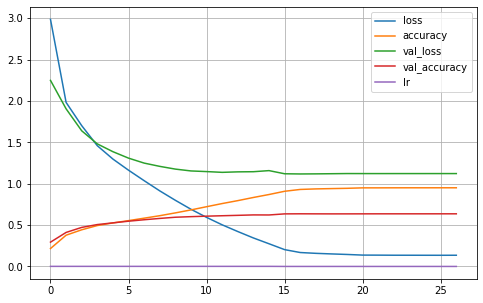

In [17]:
#get all the data and plot it
#history.history dictionary containing loss and any extra metrics 
#history.params training parameters
#history.epoch list of epochs
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

#4) Encoder-Decoder for inference

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 300)       1614300     input_3[0][0]                    
__________________________________________________________________________________________________
encoder_hidden_state (InputLaye [(None, 2048)]       0                                            
__________________________________________________________________________________________________
decoder_gru (GRU)               multiple             14438400    embedding_4[0][0]                
                                                                 encoder_hidden_state[0

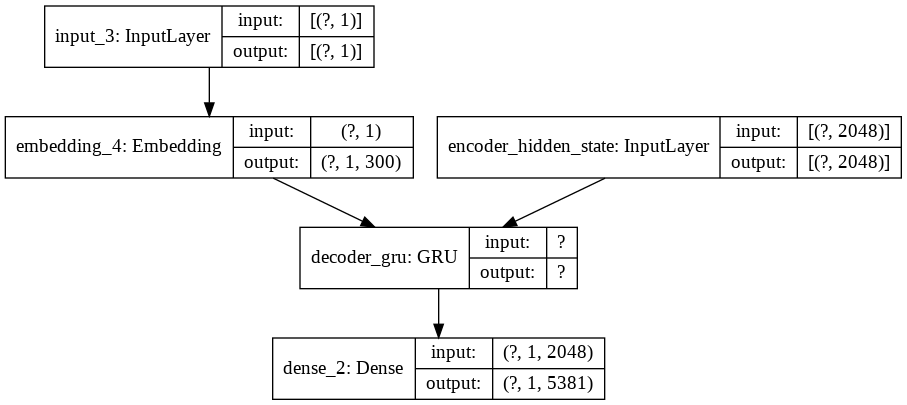

In [18]:
##############Model modified for INFERENCE##################

# encoder_model_inference is the same as in training
encoder_inf = Model(encoder_input, [encoder_output, state_h])

encoder_inf.save("/content/gdrive/My Drive/tfm/encoder_inf_model_v1.h5")
encoder_inf.save_weights("/content/gdrive/My Drive/tfm/encoder_inf_weights_v1.h5")

# decoder_model_inference
decoder_inf_state_input_h = Input(shape=(nodes * 2,), name="encoder_hidden_state") #Encoder hidden states

# decoder_inputs
decoder_inf_input = Input(shape=(1,)) #Input fro inference decoding is 1 word at a time
decoder_inf_input_emb = Embedding(en_vocab_size, 300, \
                                  weights=[emb_en], mask_zero=True)(decoder_inf_input)

# decoder
decoder_inf_gru = GRU(nodes  * 2, return_sequences=True, return_state=True, unroll=True)
decoder_inf, h_inf = decoder_gru(decoder_inf_input_emb, initial_state=decoder_inf_state_input_h)
decoder_inf_state = h_inf

decoder_inf_output = Dense(en_vocab_size, activation="softmax")(decoder_inf)


decoder_inf_model = Model([decoder_inf_input, decoder_inf_state_input_h], \
                          [decoder_inf_output, decoder_inf_state])

decoder_inf_model.summary()

plot_model(decoder_inf_model, to_file="/content/gdrive/My Drive/tfm/decoder_inf_model_v1.png", \
           show_shapes=True, show_layer_names=True)

decoder_inf_model.save("/content/gdrive/My Drive/tfm/decoder_inf_model_v1.h5")
decoder_inf_model.save_weights("/content/gdrive/My Drive/tfm/decoder_inf_weights_v1.h5")
plot_model(decoder_inf_model, to_file="/content/gdrive/My Drive/tfm/model_inf_v1.png", show_shapes=True)

#5 Inference Loop

In [19]:
#Reverse dictionary integer-word

decoding_dict = {v: k for k, v in en_tokenizer_lang.word_index.items()}

decode_zh = {v: k for k, v in zh_tokenizer_lang.word_index.items()}
decode_en = {v: k for k, v in en_tokenizer_lang.word_index.items()}

In [20]:
def translate_sentence(input_sentence, target_tokenizer, decoding_dict, output_max_len):
    encoder_output, states_value = encoder_inf.predict(input_sentence)

    target_sequence = np.zeros((1, 1))
    target_sequence[0, 0] = target_tokenizer.word_index.get("start")
    end_of_sequence = target_tokenizer.word_index.get("end")

    translated_sentence = []

    for i in range(output_max_len):
        output_token, decoder_states = decoder_inf_model.predict([target_sequence, states_value])
        id_word = np.argmax(output_token[0, -1, :])

        if id_word == end_of_sequence or input_sentence[0][i] == 0:  #this is wrong so far
            break

        decoded_word = ""

        if id_word > 0:
            decoded_word = decoding_dict[id_word]
            translated_sentence.append(decoded_word)

        target_sequence[0, 0] = id_word
        states_value = decoder_states

    return " ".join(translated_sentence)

In [21]:
src= zh_test[0:1]
zh_tokenizer_lang.sequences_to_texts(src)

['他 昨天 來 看 你 。']

In [22]:
tr = translate_sentence(src, en_tokenizer_lang, decode_en, global_max_len)
tr

'unhappy armed pride dripping massage distance'

#6) Evaluate model

In [23]:
def translate_corpus(corpus, tokenizer, decoding_dict, output_max_len):
    corpus_list = list()
    for i in range(0, len(corpus)):
        line = translate_sentence(corpus[i:i + 1], tokenizer, decoding_dict, output_max_len)
        corpus_list.append(line)
    return corpus_list

In [24]:
#######Model Evaluation######3
decode_zh = {v: k for k, v in zh_tokenizer_lang.word_index.items()}
decode_en = {v: k for k, v in en_tokenizer_lang.word_index.items()}

decode_zh.update({0: "0"})
decode_en.update({0: "0"})

In [25]:
def decode_source(sentence):
    sent = np.ndarray.tolist(sentence)
    words = [decode_zh.get(letter) for letter in sent]
    my_texts = (["".join(words[i]) for i in range(len(words))])
    text = [i for i in my_texts if i != "0"]
    return text


def decode_target(sentence):
    sent = np.ndarray.tolist(sentence)
    words = [decode_en.get(letter) for letter in sent]
    my_texts = (["".join(words[i]) for i in range(len(words))])
    text = [i for i in my_texts if i != "0"]
    return text


In [26]:
# tokenizer = en_tokenizer_lang
# output_max_len = global_max_len
# decoding_dict = decode_zh
def evaluate_model(source_corpus, target_corpus):
    original = source_corpus   #format: list of sentences as words
    actual = [decode_target(target_corpus[i]) for i in
              range(len(target_corpus))] #format: list of sentence as tokens
    predicted = translate_corpus(source_corpus, en_tokenizer_lang, \
                                 decoding_dict=decode_en, output_max_len=global_max_len)

    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [27]:
c = zh_test[0:1000]
p = en_test[0:1000]
evaluacion = evaluate_model(c, p)

BLEU-1: 0.277710
BLEU-2: 0.148131
BLEU-3: 0.078011
BLEU-4: 0.022116
